#### PMEmo dataset без аугментации

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import csv
import pandas as pd
import numpy as np
from collections import Counter
import random
import json
import shutil
import random

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.models import resnet18
from torch.autograd import Variable

import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models

### Переносим файлы

In [3]:
shutil.copy('/content/gdrive/MyDrive/new_PMEmo/mfcc_pmemo.zip', './')

'./mfcc_pmemo.zip'

In [ ]:
!unzip /content/mfcc_pmemo.zip

### Агументация

In [5]:
class DataPreprocessor():
  """
    Create annotation for balanced dataset
    """
  def __init__(self, df_dir):
    self.__df = pd.read_csv(df_dir)
    self.__make_new_dataset(size=1441)


  def __get_quadrants(self, arousal, valence):
    """
    Determine the quadrant based on arousal and valence values.

    Args:
      arousal (float): Arousal value.
      valence (float): Valence value.

    Returns:
      int: The quadrant number (1, 2, 3, or 4).
    """
    mid_val = 0.5
    if valence > mid_val:
      return 4 if arousal < mid_val else 1
    else:
      return 3 if arousal < mid_val else 2


  def __add_quadrants_columns(self, quadrants):
    """
    Add a 'quadrant' column to the DataFrame.

    Args:
      quadrants (list): List of quadrant numbers.

    Returns:
      pandas.DataFrame: Updated DataFrame with the 'quadrant' column.
    """
    qudrants_df = pd.DataFrame(quadrants, columns = ['quadrant'])
    self.__df = pd.concat([self.__df, qudrants_df], axis=1)
    return self.__df


  def __count_quadrants(self):
    """
    Count the number of samples in each quadrant.

    Returns:
      tuple: A tuple containing a list of quadrants and a Counter object with quadrant counts.
    """
    quadrants = []
    for row in range(self.__df.shape[0]):
      arousal = self.__df.iloc[row]['arousal']
      valence = self.__df.iloc[row]['valence']
      quadrants.append(self.__get_quadrants(arousal, valence))
    quadrants_counter = Counter(quadrants)
    for key in quadrants_counter.keys():
      print(f'Quadrat {key} : {quadrants_counter[key]} samples')
    return quadrants, quadrants_counter


  def __save_csv(self):
    """
    Save the DataFrame as a CSV file.

    Returns:
      None
    """
    self.__df.to_csv('./data/processed/temp_annotation.csv', index=False)


  def __make_new_dataset(self, size=1500):
    """
    Create a new dataset with a specified size by balancing the samples in each quadrant.

    Args:
      size (int): The desired size of each quadrants.

    Returns:
      None
    """
    quadrants, quadrants_counter = self.__count_quadrants()
    self.__df = self.__add_quadrants_columns(quadrants)
    for key in quadrants_counter.keys():
      quadrant_size = quadrants_counter[key]
      indexes = list(self.__df[self.__df['quadrant'] == key].index)

      if quadrant_size >= size:
        del_size = quadrants_counter[key] - size
        del_indexes = random.sample(indexes, del_size)
        self.__df.drop(index=del_indexes, inplace=True)

      else:
        added_size = size - quadrant_size
        added_indexes =  random.sample(indexes, added_size)
        self.__df = pd.concat([self.__df, self.__df.loc[added_indexes]], axis=0).reset_index(drop=True)
    self.__save_csv()

In [9]:
DataPreprocessor('/content/new_annotation_pmemo.csv')

Quadrat 4 : 1441 samples
Quadrat 3 : 2702 samples
Quadrat 2 : 1851 samples
Quadrat 1 : 12218 samples


### Создание train/valid датасета

In [ ]:
df = pd.read_csv('/content/data/processed/temp_annotation.csv')

In [117]:
x_train, x_valid = train_test_split(df, test_size=0.25,
                                                      random_state=42)

In [118]:
x_train.to_csv('train_annotation.csv', index=False)
x_valid.to_csv('valid_annotation.csv', index=False)

In [25]:
def visualization(valence, arousal):
  plt.figure(figsize=(4, 4))

  plt.xlim(0, 1)
  plt.ylim(0, 1)

  plt.axvline(x=0.5, color='grey', linestyle='--')
  plt.axhline(y=0.5, color='grey', linestyle='--')

  plt.scatter(valence, arousal)

  plt.xlabel('Valence')
  plt.ylabel('Arousal')

  plt.title('Дж. Рассел: arousal и valence')

  plt.show()

### Среднее и std

In [119]:
songs_dir = '/content/mfcc'
songs = list(pd.read_csv('/content/data/processed/temp_annotation.csv')['song_id'].values)
mfccs = []
for song in songs:
  mfcc = torch.tensor(np.load(os.path.join(songs_dir, f'{song}.npy')), dtype=torch.float)
  mfccs.append(mfcc)
combined = torch.cat(mfccs, dim=0)
print(torch.mean(combined))
print(torch.std(combined))

tensor(13.6983)
tensor(53.4555)


In [120]:
class MusicDataset(Dataset):
  def __init__(self, annot_dir, mfcc_dir):
    self.mfcc_dir = mfcc_dir
    self.annot_df = pd.read_csv(annot_dir)
    self.music_name = list(self.annot_df['song_id'].values)

  def __len__(self):
    return len(self.music_name)

  def normalize_mfccs(self, mfcc):
    mean = torch.tensor(13.6983, dtype=torch.float)
    std = torch.tensor(53.4555, dtype=torch.float)
    return (mfcc - mean) / std

  def __getitem__(self, idx):
    series =  self.annot_df.iloc[idx]
    mfcc = self.normalize_mfccs(torch.tensor(np.load(os.path.join(self.mfcc_dir, f"{series['song_id']}.npy")), dtype=torch.float))
    arousal = torch.tensor(series['arousal'], dtype=torch.float)
    valence = torch.tensor(series['valence'], dtype=torch.float)
    return mfcc, arousal, valence

In [121]:
train_dir = '/content/train_annotation.csv'
valid_dir = '/content/valid_annotation.csv'
mfcc_dir = '/content/mfcc'
train_dataset = MusicDataset(train_dir, mfcc_dir)
valid_dataset = MusicDataset(valid_dir, mfcc_dir)

In [122]:
train_size = len(train_dataset)
valid_size = len(valid_dataset)
print(train_size)
print(valid_size)

4473
1491


In [123]:
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [124]:
mfcc, arousal, valence = next(iter(train_data))
mfcc.shape

torch.Size([64, 20, 100])

In [133]:
class EmotionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(20, 32, 3, 1),
                                    nn.BatchNorm1d(32),
                                    nn.LeakyReLU(),
                                    nn.AvgPool1d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv1d(32, 64, 3, 1),
                                    nn.BatchNorm1d(64),
                                    nn.LeakyReLU(),
                                   nn.AvgPool1d(2, 2))
        self.conv3 = nn.Sequential(nn.Conv1d(64, 128, 3, 1),
                                    nn.BatchNorm1d(128),
                                    nn.LeakyReLU(),
                                    nn.AvgPool1d(2, 2))
        self.conv4 = nn.Sequential(nn.Conv1d(128, 64, 3, 1),
                                    nn.BatchNorm1d(64),
                                    nn.LeakyReLU(),
                                   nn.AvgPool1d(2, 2))
        self.conv5 = nn.Sequential(nn.Conv1d(64, 32, 3, 1),
                                    nn.BatchNorm1d(32),
                                    nn.LeakyReLU(),
                                    nn.AvgPool1d(2, 2))
        self.fc1 = nn.Sequential(nn.Linear(32, 16),
                                  nn.Dropout(0.5),
                                  nn.LeakyReLU())
        self.fc2 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(self.conv2(x))
        x = self.conv3(x)
        x = self.dropout(self.conv4(x))
        x = self.conv5(x)
        x = x.view(-1, x.shape[1] * x.shape[2])
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [134]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [135]:
model = EmotionModel()
model = model.to(device)

In [136]:
model(mfcc.to(device)).squeeze().shape

torch.Size([64])

In [137]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
metric = nn.L1Loss()

In [138]:
with open('/content/gdrive/MyDrive/CNN_one_model/valence_history8.csv', 'w') as file:
          writer = csv.writer(file)
          writer.writerows([['epoch', 'train_loss', 'train_metric', 'valid_loss', 'valid_metric']])

In [139]:
def train_model(model, n_epochs, optimizer, criterion, target, metric):

    history = {
    'train_losses': [],
    'valid_losses': [],
    'train_metrics': [],
    'valid_metrics': []
    }

    best_metrics = {'epoch': 0, 'valid_loss': 0, 'valid_metric': 0}

    for epoch in range(n_epochs):
        train_losses_iter = []
        train_metrics_iter = []
        model.train()
        j=0
        for music, arousal, valence in train_data:
            if j % 10 == 0:
              print(f'{j} итерация в train')
            j+=1
            music, arousal, valence = music.to(device), arousal.to(device), valence.to(device)
            out = model(music)
            if target == 'arousal':
                loss = torch.sqrt(criterion(out.squeeze(), arousal))
                metric_res = metric(out.squeeze(), arousal)
            elif target == 'valence':
                loss = torch.sqrt(criterion(out.squeeze(), valence))
                metric_res = metric(out.squeeze(), valence)

            train_losses_iter.append(loss.item())
            train_metrics_iter.append(metric_res.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        history['train_losses'].append(np.mean(train_losses_iter))
        history['train_metrics'].append(np.mean(train_metrics_iter))

        valid_losses_iter = []
        valid_metrics_iter = []
        model.eval()

        i=0
        for music, arousal, valence in valid_data:
            i+= 1
            if i % 10 == 0:
                print(f'{i} итерация в valid')

            music, arousal, valence = music.to(device), arousal.to(device), valence.to(device)
            out = model(music)
            if target == 'arousal':
                loss = torch.sqrt(criterion(out.squeeze(), arousal))
                metric_res = metric(out.squeeze(), arousal)
            elif target == 'valence':
                loss = torch.sqrt(criterion(out.squeeze(), valence))
                metric_res = metric(out.squeeze(), valence)

            valid_losses_iter.append(loss.item())
            valid_metrics_iter.append(metric_res.item())

        history['valid_losses'].append(np.mean(valid_losses_iter))
        history['valid_metrics'].append(np.mean(valid_metrics_iter))
        with open('/content/gdrive/MyDrive/CNN_one_model/valence_history8.csv', 'a') as file:
          writer = csv.writer(file)
          writer.writerows([[epoch, round(history["train_losses"][-1], 4),
                             round(history["train_metrics"][-1], 4),
                             round(history["valid_losses"][-1], 4),
                             round(history["valid_metrics"][-1], 4)]])

        if (best_metrics['valid_loss'] == 0) or (best_metrics['valid_loss'] > history["valid_losses"][-1]):
          best_metrics['epoch'] = epoch
          best_metrics['valid_loss'] = history["valid_losses"][-1]
          best_metrics['valid_metric'] = history["valid_metrics"][-1]
          torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_one_model/valence_weights8/best_model.pt')
          print(f"best results: epoch {best_metrics['epoch']}, valid loss {best_metrics['valid_loss']}, valid metric {best_metrics['valid_metric']}")

          with open('/content/gdrive/MyDrive/CNN_one_model/valence_best_res8.json', 'w') as outfile:
            json.dump(best_metrics, outfile)

        torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_one_model/valence_weights8/each_epochs.pt')
        if epoch == 100:
          torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_one_model/valence_weights8/100_epochs.pt')
        if epoch == 199:
          torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_one_model/valence_weights8/200_epochs.pt')

        print(f'epoch: {epoch}\n'
        f'train: loss {history["train_losses"][-1]:.4f}\n'
        f'train: metric {history["train_metrics"][-1]:.4f}\n'
        f'valid: loss {history["valid_losses"][-1]:.4f}\n'
        f'valid: metric {history["valid_metrics"][-1]:.4f}')
        print(f'{"-"*35}')
        print()
    return history

In [ ]:
history = train_model(model, 600, optimizer, criterion, 'valence', metric)

### Сравнение метрик

### Для arousal

In [145]:
class Visualizer():
    def __init__(self, model_arousal, model_valence, valid_dataset):
        self.device = device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_arousal = model_arousal.to(self.device)
        self.model_arousal.eval()
        self.model_valence = model_valence.to(self.device)
        self.model_valence.eval()
        self.valid_data = valid_dataset
        self.arousal_history_dir = '/content/gdrive/MyDrive/CNN_one_model/arousal_history7.csv'
        self.arousal_best_res_dir = '/content/gdrive/MyDrive/CNN_one_model/arousal_best_res7.json'
        self.valence_history_dir = '/content/gdrive/MyDrive/CNN_one_model/valence_history7.csv'
        self.valence_best_res_dir = '/content/gdrive/MyDrive/CNN_one_model/valence_best_res7.json'
        sns.set_style('whitegrid')
        sns.set_palette('husl')


    def get_model_results(self):
        true_val_arousal = []
        pred_val_arousal = []
        true_val_valence = []
        pred_val_valence = []
        for music, arousal, valence in self.valid_data:
          out_arousal = self.model_arousal(music.to(self.device))
          out_valence = self.model_valence(music.to(self.device))
          true_val_arousal+=list(arousal.cpu().detach().numpy())
          true_val_valence+=list(valence.cpu().detach().numpy())
          pred_val_arousal+=list(out_arousal.squeeze().cpu().detach().numpy())
          pred_val_valence+=list(out_valence.squeeze().cpu().detach().numpy())
        return true_val_arousal, pred_val_arousal, true_val_valence, pred_val_valence


    def get_arousal_valence_plot(self, axis1):
        arousal_true, arousal_pred, valence_true, valence_pred = self.get_model_results()
        axis1.set_xlim(0, 1)
        axis1.set_ylim(0, 1)
        axis1.axvline(x=0.5, color='grey', linestyle='--')
        axis1.axhline(y=0.5, color='grey', linestyle='--')
        for index, (arousal_true, valence_true) in enumerate(zip(arousal_true, valence_true)):
          colors = {1: 'blue', 2: 'red', 3: 'green', 4: 'purple'}
          quadrant = self.get_quadrants(arousal_true, valence_true)
          axis1.scatter(valence_pred[index], arousal_pred[index], color=colors[quadrant], s=1)
        axis1.set_xlabel('Valence')
        axis1.set_ylabel('Arousal')
        axis1.set_title('Дж. Рассел: arousal и valence')


    def get_quadrants(self, arousal, valence):
        mid_val = 0.5
        if valence > mid_val:
            return 4 if arousal < mid_val else 1
        else:
            return 3 if arousal < mid_val else 2


    def get_quadrants_res(self):
        true_val_arosual, pred_val_arosual, true_val_valence, pred_val_valence = self.get_model_results()
        true = []
        pred = []
        for arousal, valence in zip(pred_val_arosual, pred_val_valence):
            pred.append(self.get_quadrants(arousal, valence))
        for arousal, valence in zip(true_val_arosual, true_val_valence):
            true.append(self.get_quadrants(arousal, valence))
        quadrants = {1: [], 2: [], 3: [], 4: []}
        for index, quadrant in enumerate(true):
            quadrants[quadrant].append(1) if pred[index] == quadrant else quadrants[quadrant].append(0)
        df = pd.DataFrame({'Quadrant 1': [np.mean(quadrants[1])],
                           'Quadrant 2': [np.mean(quadrants[2])],
                           'Quadrant 3': [np.mean(quadrants[3])],
                           'Quadrant 4': [np.mean(quadrants[4])]})
        return df


    def get_range(self, target='arousal'):
        true_val_arosual, pred_val_arosual, true_val_valence, pred_val_valence = self.get_model_results()
        pred_val = pred_val_arosual if target == 'arousal' else pred_val_valence
        min_val = np.min(pred_val)
        max_val = np.max(pred_val)
        df = pd.DataFrame({'min_val': min_val,
                           'max_val': max_val}, index=[target])
        return df


    def get_best_res(self, target='arousal'):
        dir = self.arousal_best_res_dir if target == 'arousal' else self.valence_best_res_dir
        with open(dir) as f:
            data = json.load(f)
        df = pd.DataFrame({'epoch': [data['epoch']],
                           'valid_loss': [data['valid_loss']],
                           'valid_metric': [data['valid_metric']]}, index=[target])
        return df


    def get_history_plot(self, axis1, axis2, target='arousal'):
        if target == 'arousal':
            df = pd.read_csv(self.arousal_history_dir)
        elif target == 'valence':
            df = pd.read_csv(self.valence_history_dir)
        axis1.plot(df['epoch'], df['train_loss'], label='train')
        axis1.plot(df['epoch'], df['valid_loss'], label='valid')
        axis1.legend()
        axis1.set_xlabel('epochs')
        axis1.set_ylabel('loss')
        axis1.set_title(f'{target} loss function')
        axis2.plot(df['epoch'], df['train_metric'], label='train')
        axis2.plot(df['epoch'], df['valid_metric'], label='valid')
        axis2.legend()
        axis2.set_xlabel('epochs')
        axis2.set_ylabel('metric')
        axis2.set_title(f'{target} metrics')
        plt.tight_layout()


    def get_true_pred_plot(self, axis, target='arousal'):
        true_val_arosual, pred_val_arosual, true_val_valence, pred_val_valence = self.get_model_results()
        axis.set_aspect('equal')
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        plt.ylim(0, 1)
        plt.xlim(0, 1)
        if target == 'arousal':
            axis.set_xticks([])
            axis.spines['bottom'].set_visible(False)
            axis.spines['left'].set_position('center')
            axis.text(0.40, 1.1, 'Arousal', verticalalignment='top')
            x = np.linspace(0, 1, len(true_val_arosual), endpoint=True)
            idx = np.argsort(pred_val_arosual)
            true_sorted_arousal = np.array(true_val_arosual)[idx.astype(int)]
            pred_sorted_arousal = np.array(pred_val_arosual)[idx.astype(int)]
            axis.plot(x, pred_sorted_arousal, lw=2, color='purple')
            axis.scatter(x, true_sorted_arousal, s=1)
        if target == 'valence':
            axis.set_yticks([])
            axis.spines['left'].set_visible(False)
            axis.spines['bottom'].set_position('center')
            axis.text(1.01, 0.515, 'Valence', horizontalalignment='right')
            y = np.linspace(0, 1, len(true_val_valence), endpoint=True)
            idx = np.argsort(pred_val_valence)
            true_sorted_arousal = np.array(true_val_valence)[idx.astype(int)]
            pred_sorted_arousal = np.array(pred_val_valence)[idx.astype(int)]
            axis.plot(pred_sorted_arousal, y, lw=2, color='purple')
            axis.scatter(true_sorted_arousal, y, s=1)


    def get_full_visualisation(self):
        fig, axes = plt.subplots(4, 2, figsize=(7, 12))
        self.get_history_plot(axes[0, 0], axes[0, 1], target='arousal')
        self.get_history_plot(axes[1, 0], axes[1, 1], target='valence')
        self.get_true_pred_plot(axes[2, 0], target='arousal')
        self.get_true_pred_plot(axes[2, 1], target='valence')
        self.get_arousal_valence_plot(axes[3, 0])
        plt.tight_layout()
        plt.show()

        arousal_metrics_df = self.get_best_res('arousal')
        arousal_range_df = self.get_range(target='arousal')
        arousal_df = pd.concat([arousal_metrics_df,arousal_range_df], axis=1)
        valence_metrics_df = self.get_best_res('valence')
        valence_range_df = self.get_range(target='valence')
        valence_df = pd.concat([valence_metrics_df,valence_range_df], axis=1)
        df = pd.concat([arousal_df, valence_df])
        quadrant_df = self.get_quadrants_res()
        display(df)
        display(quadrant_df)

In [142]:
model_arousal = EmotionModel()
model_arousal.load_state_dict(torch.load('/content/gdrive/MyDrive/CNN_one_model/arousal_weights8/best_model.pt', map_location=torch.device('cpu')))
model_valence = EmotionModel()
model_valence.load_state_dict(torch.load('/content/gdrive/MyDrive/CNN_one_model/valence_weights8/best_model.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [143]:
visualiser = Visualizer(model_arousal, model_valence, valid_data)

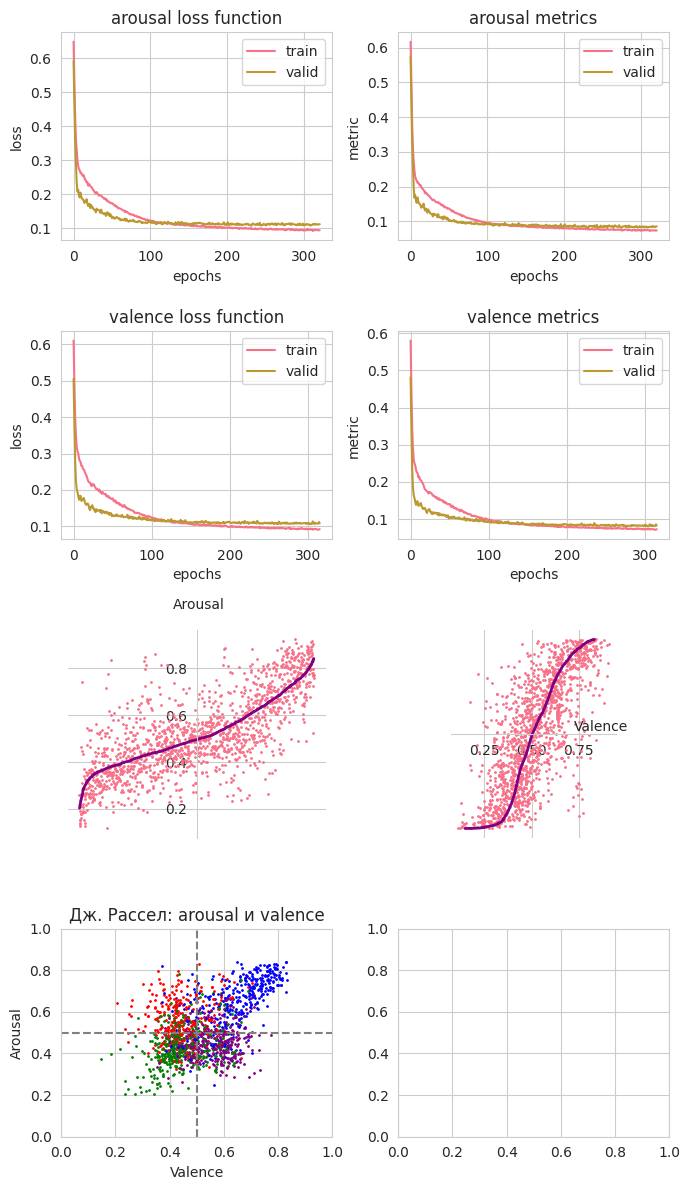

,epoch,valid_loss,valid_metric,min_val,max_val
arousal,309,0.108375,0.082370,0.203454,0.841843
valence,303,0.106244,0.080363,0.148297,0.832545


,Quadrant 1,Quadrant 2,Quadrant 3,Quadrant 4
0,0.754054,0.498525,0.643229,0.560345


In [86]:
visualiser.get_full_visualisation()

In [108]:
def normalize_mfccs(mfcc):
    mean = torch.tensor(13.6983, dtype=torch.float)
    std = torch.tensor(53.4555, dtype=torch.float)
    return (mfcc - mean) / std

def pipeline(song):
  music, sr = librosa.load(song, mono=True, sr=44100)
  music_length = music.shape[0] // sr
  frame_duration = 1
  frame_length = int(frame_duration * sr)
  #hop_length = int(10 * sr)
  music = librosa.util.frame(music, frame_length=frame_length, hop_length=frame_length, axis=0)
  model_arousal = EmotionModel()
  model_arousal.load_state_dict(torch.load('/content/gdrive/MyDrive/CNN_one_model/arousal_weights8/best_model.pt', map_location=torch.device('cpu')))
  model_valence = EmotionModel()
  model_valence.load_state_dict(torch.load('/content/gdrive/MyDrive/CNN_one_model/valence_weights8/best_model.pt', map_location=torch.device('cpu')))
  model_arousal = model_arousal.to(device)
  model_valence = model_valence.to(device)
  model_arousal.eval()
  model_valence.eval()
  valence = []
  arousal = []
  for elem in music:
    mfcc = get_mfcc(elem, sr)
    mfcc = torch.tensor(mfcc, dtype=torch.float)
    mfcc = normalize_mfccs(mfcc)
    mfcc = torch.unsqueeze(mfcc, 0)
    valence_sec = model_valence(mfcc.to(device)).squeeze()
    arousal_sec = model_arousal(mfcc.to(device)).squeeze()
    valence.append(valence_sec.cpu().detach().numpy())
    arousal.append(arousal_sec.cpu().detach().numpy())
  return np.mean(valence), np.mean(arousal)

In [106]:
def get_quadrants(arousal, valence):
        mid_val = 0.5
        if valence > mid_val:
            return 'Q4' if arousal < mid_val else 'Q1'
        else:
            return 'Q3' if arousal < mid_val else 'Q2'


def get_quadrants_res():
      test = pd.read_excel('/content/gdrive/MyDrive/CNN_one_model/MRE/MER-Audio-dataset.xls')
      dict_quadrants = {'Q1': [], 'Q2': [], 'Q3': [], 'Q4': []}
      for song in os.listdir('/content/gdrive/MyDrive/CNN_one_model/MRE/Corpus-Audio-162'):
        valence, arousal = pipeline(f'/content/gdrive/MyDrive/CNN_one_model/MRE/Corpus-Audio-162/{song}')
        song_code = song.split('-')[0] if '-' in song else song.split('.')[0]
        quadrant = test[test['Song Code'] == song_code]['Quadrant'].values
        if len(quadrant) == 0:
            continue
        pred_val = get_quadrants(arousal, valence)
        dict_quadrants[quadrant[0]].append(1) if pred_val == quadrant else dict_quadrants[quadrant[0]].append(0)
      print(f"Quadrant 1: {np.mean(dict_quadrants['Q1'])}")
      print(f"Quadrant 2: {np.mean(dict_quadrants['Q2'])}")
      print(f"Quadrant 3: {np.mean(dict_quadrants['Q3'])}")
      print(f"Quadrant 4: {np.mean(dict_quadrants['Q4'])}")




In [70]:
get_quadrants_res()

Quadrant 1: 0.5192307692307693
Quadrant 2: 0.2222222222222222
Quadrant 3: 0.6333333333333333
Quadrant 4: 0.35294117647058826
